In [2]:
from scipy.stats import entropy, kurtosis

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import re

## Benign Behaviour

In [2]:
df = pd.read_csv("/Users/c22105357/Documents/gotham-network-packet-labeller/data/raw/normal/all_benign_data.txt", sep=";")
df["device_type"] = df["device"].apply(lambda x: re.match(r"([a-zA-Z\-]+)-([0-9]+)", x).group(1))
df['timestamp'] = df['timestamp'].astype(float).astype(int)

In [3]:
cols = ["frame.time", "frame.len", "frame.protocols", "ip.proto", "ip.src", "ip.dst", "label"]

dfs = []
for filename in glob.glob("../data/ready/*.csv"):
    processed_chunks = []
    for chunk in pd.read_csv(filename, sep=",", usecols=cols, low_memory=False, chunksize=10000):
        processed_chunks.append(chunk)

    # Concatenate all the chunks into a single DataFrame
    df = pd.concat(processed_chunks)
    df['device'] = filename.split('/')[-1].rstrip('.csv')
    dfs.append(df)

In [4]:
final_df = pd.concat(dfs)

In [26]:
attack_group = {
    "Normal": "Normal",
    "TCP Scan": "Network Scanning",
    "UDP Scan": "Network Scanning",
    "Telnet Brute Force": "Brute Force",
    "Reporting": "Infection",
    "Ingress Tool Transfer": "Infection",
    "File Download": "Infection",
    "CoAP Amplification": "DoS",
    "Merlin TCP Flooding": "DoS",
    "Merlin UDP Flooding": "DoS",
    "Merlin ICMP Flooding": "DoS",
    "Merlin C&C Communication": "C&C Communication",
    "Mirai TCP Flooding": "DoS",
    "Mirai UDP Flooding": "DoS",
    "Mirai GRE Flooding": "DoS",
    "Mirai C&C Communication": "C&C Communication" 
}
final_df['label_category'] = final_df['label'].map(lambda x: attack_group.get(x, 'Other'))

In [34]:
final_df = final_df[final_df['label_category'] != 'Other']
a = final_df.groupby('device')['label_category'].value_counts(normalize=True).unstack()
a = a.fillna(0)
# a = a.drop("Other", axis=1)

In [6]:
import json

with open("../metadata/metadata-normal.json", "r") as read_file:
    normal = json.load(read_file)

In [7]:
net1 = ['iotsim-air-quality', 'iotsim-city-power', 'iotsim-domotic-monitor', 'iotsim-ip-camera-street']
net2 = ['iotsim-building-monitor', 'iotsim-ip-camera-museum', 'iotsim-stream-consumer']
net3 = ['iotsim-predictive-maintenance', 'iotsim-cooler-motor']
net4 = ['iotsim-hydraulic-system', 'iotsim-combined-cycle-tls', 'iotsim-combined-cycle']

In [8]:
networks = []
for net in [net1, net2, net3, net4]:
    new = []
    for dev in net:
        number_of_instance = len(normal[dev]['device_ip'])
        new += [f"{dev}-{i}" for i in range(1, number_of_instance+1)]

    networks.append(new)

In [32]:
a.sum(axis=1)

device
iotsim-air-quality-1               0.999472
iotsim-building-monitor-1          0.999992
iotsim-building-monitor-2          1.000000
iotsim-building-monitor-3          1.000000
iotsim-building-monitor-4          1.000000
                                     ...   
iotsim-predictive-maintenance-7    1.000000
iotsim-predictive-maintenance-8    1.000000
iotsim-predictive-maintenance-9    1.000000
iotsim-stream-consumer-1           1.000000
iotsim-stream-consumer-2           1.000000
Length: 78, dtype: float64

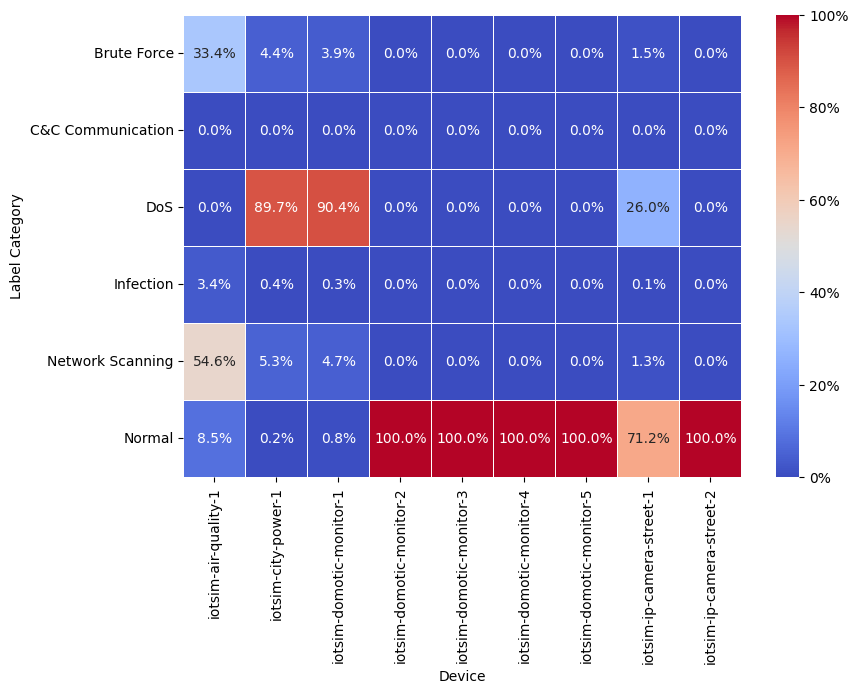

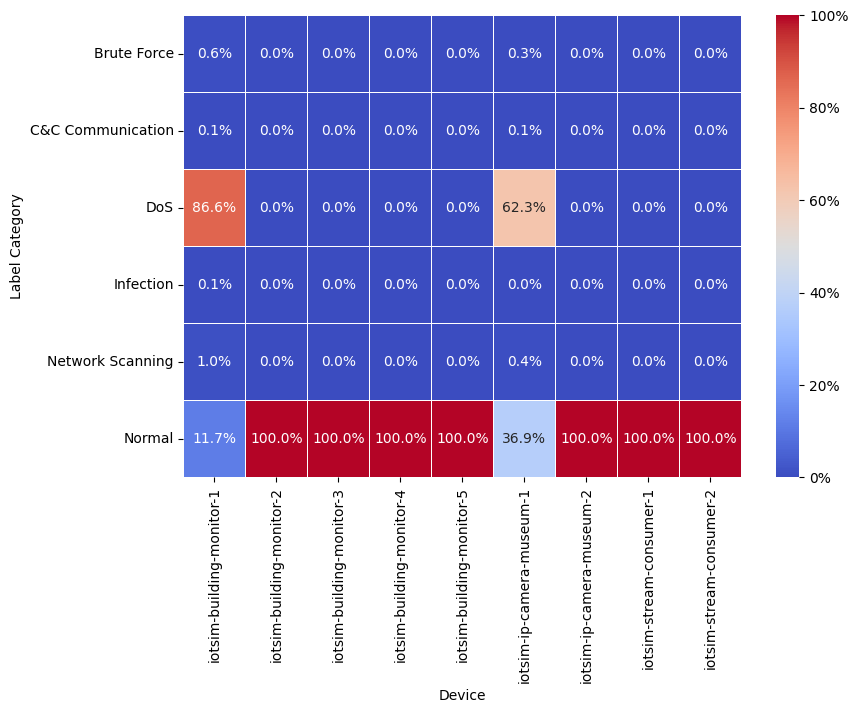

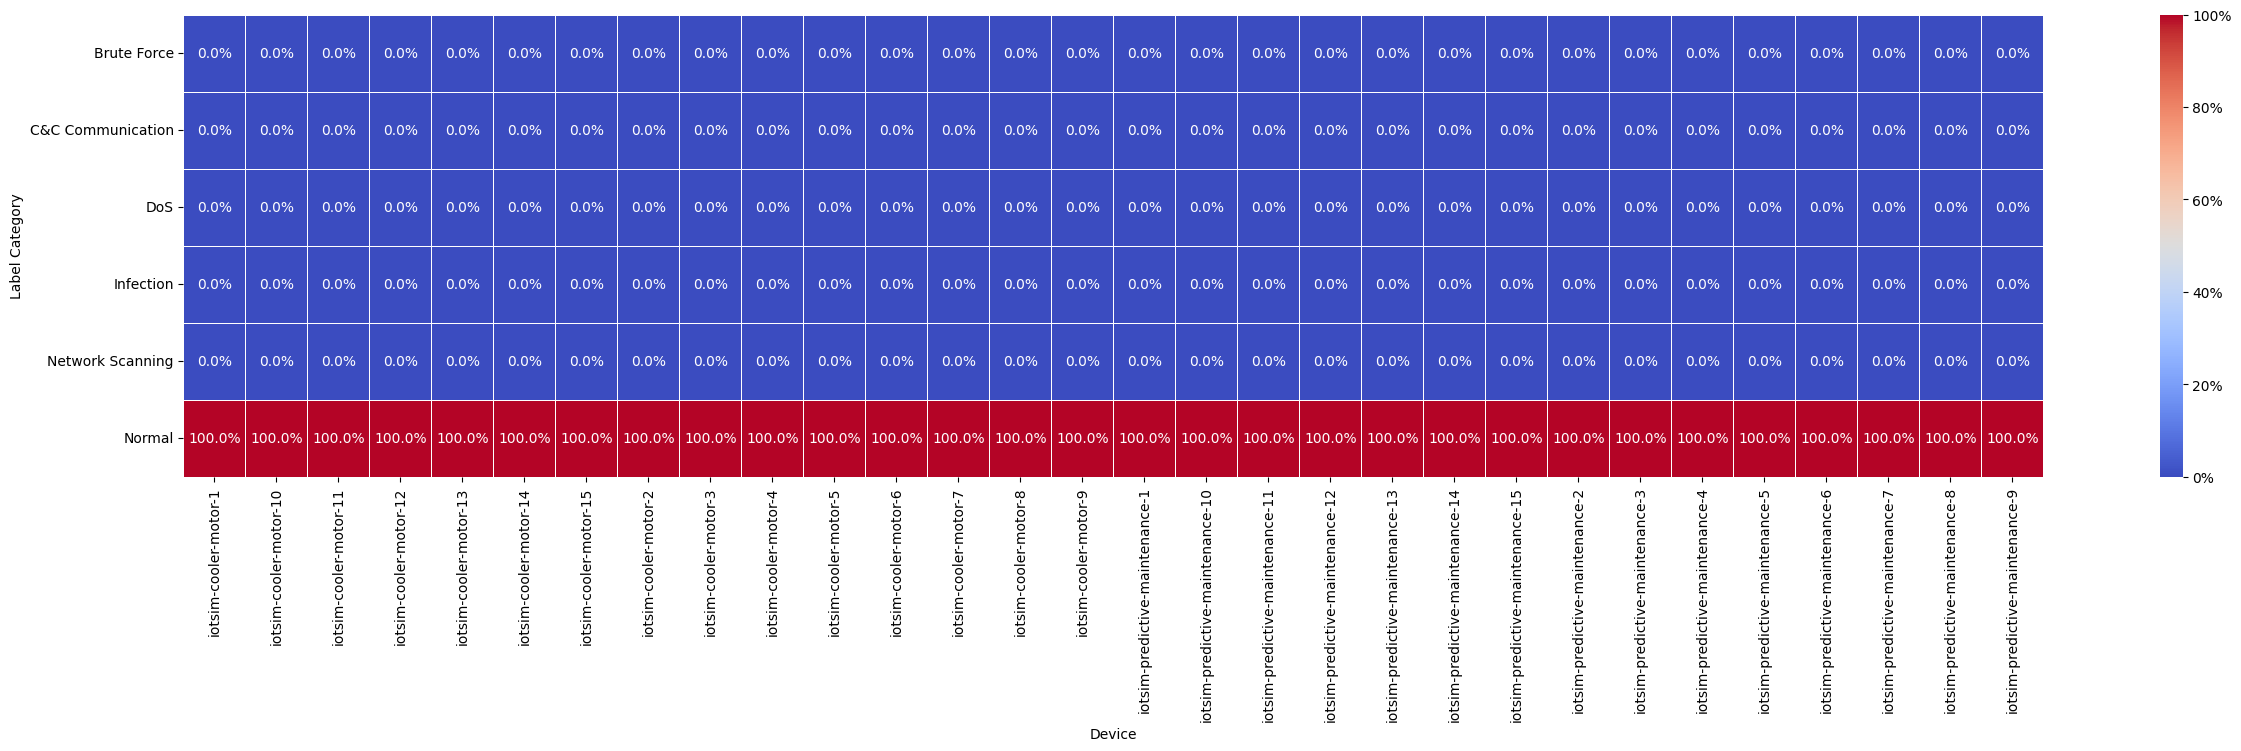

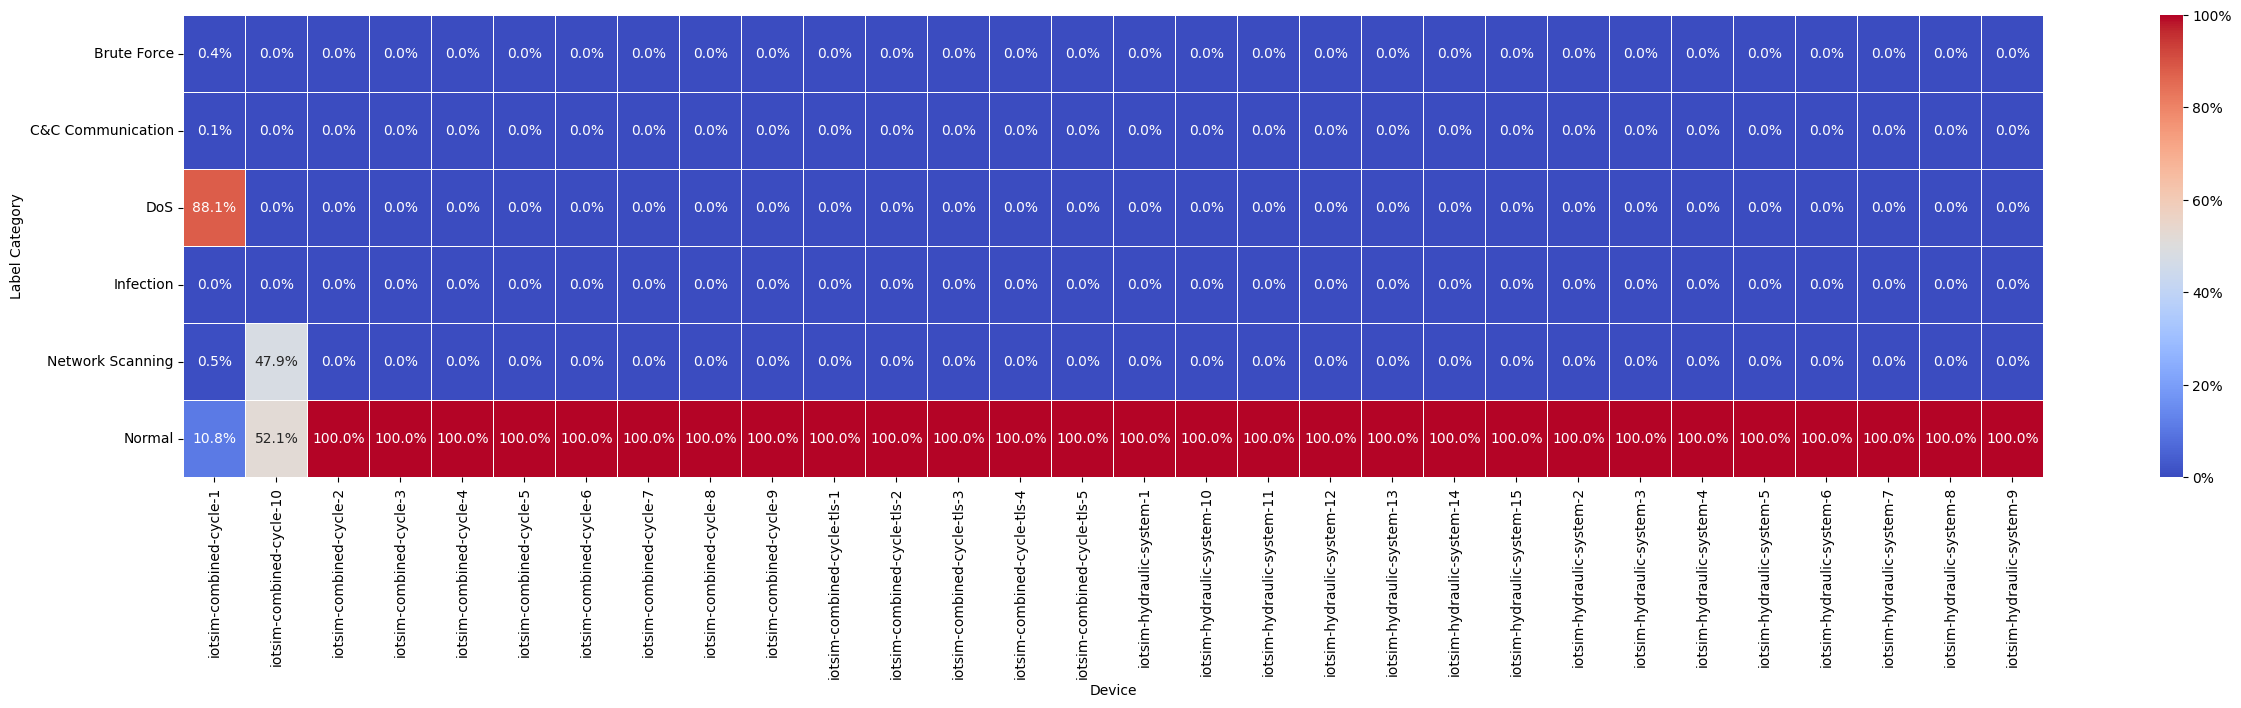

In [52]:
for i, network in enumerate(networks, 1):

    plt.figure(figsize=(len(network), 6))
    ax = sns.heatmap(a[a.index.isin(network)].T * 100, fmt=".1f", annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'format': '%.0f%\%'})
    # Format color bar with percentage symbol
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(cbar.get_ticks())  # Refresh the ticks
    cbar.set_ticklabels([f"{int(x)}%" for x in cbar.get_ticks()])  # Add % symbol to ticks

    # Format the annotations with percentage sign
    for text in ax.texts:  # Iterate through the text annotations
        text.set_text(f"{text.get_text()}%")

    # Add axis labels and title
    plt.xlabel("Device")
    plt.ylabel("Label Category")
    plt.savefig(f"heatmap_high_res_{i}.pdf", dpi=300, bbox_inches='tight')
    # plt.title("Heatmap with Percentages")
    # plt.show()

In [6]:
a['Benign'] = a['Normal'] / a.sum(axis=1)
a['Malicious'] = 1 - a['Benign'] 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data for heatmap (device × class matrix)
class_distribution_matrix = final_df.pivot_table(index='device', columns='label', aggfunc='count', fill_value=0)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(class_distribution_matrix, annot=True, cmap='YlGnBu', fmt='d')

# Customize plot
plt.title('Class Distribution Across IoT Devices')
plt.xlabel('Class Label')
plt.ylabel('IoT Device')
plt.tight_layout()
plt.show()


: 

: 

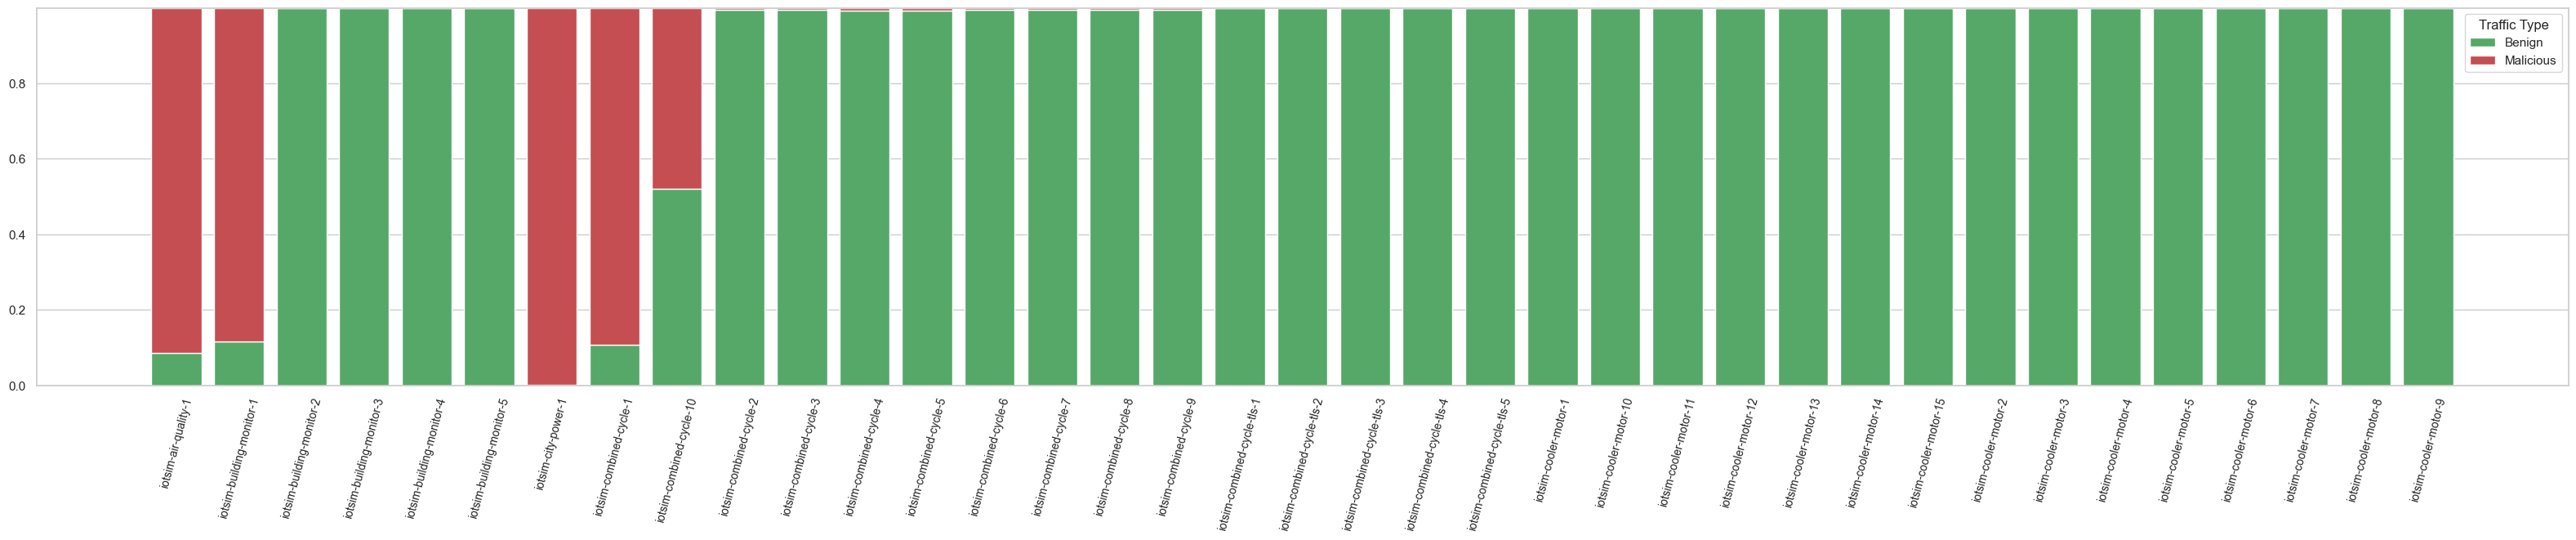

In [65]:
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
b = a.iloc[:37]
plt.figure(figsize=(40, 6))
plt.bar(list(b.index), b['Benign'].values, color='g', label='Benign')
plt.bar(list(b.index), b['Malicious'].values, bottom=b['Benign'].values, color='r', label='Malicious')

plt.xticks(rotation=75, fontsize=10)
plt.legend(title='Traffic Type')
plt.show()

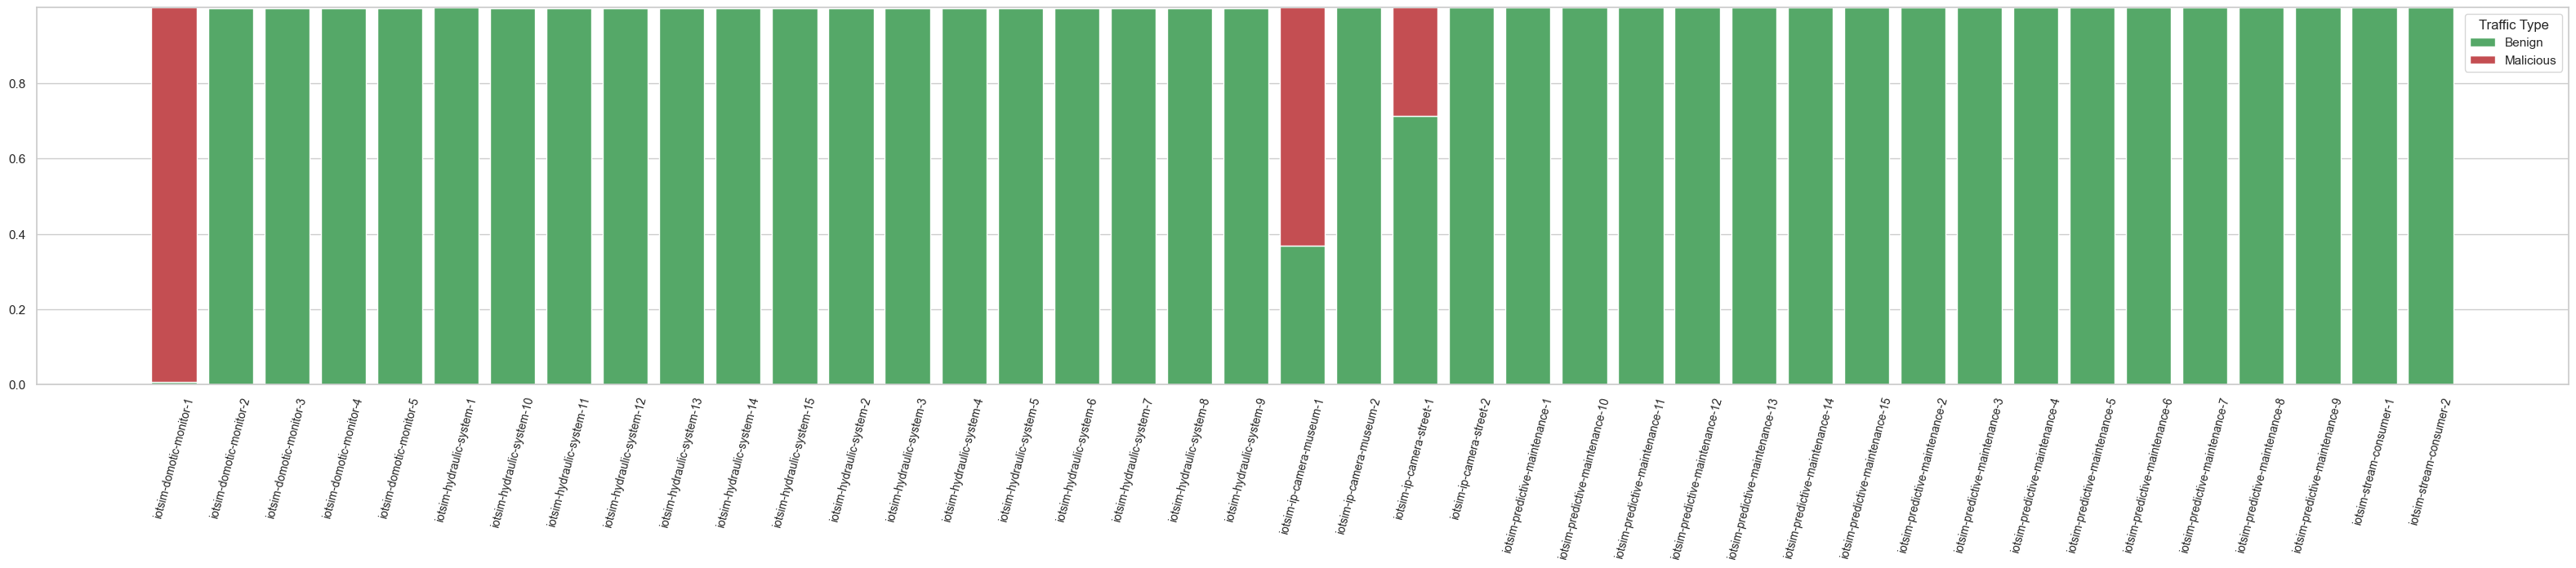

In [66]:
b = a.iloc[37:]
plt.figure(figsize=(40, 6))
plt.bar(list(b.index), b['Benign'].values, color='g', label='Benign')
plt.bar(list(b.index), b['Malicious'].values, bottom=b['Benign'].values, color='r', label='Malicious')

plt.xticks(rotation=75, fontsize=10)
plt.legend(title='Traffic Type')
plt.show()

/var/folders/2l/fpckxx395fs2zmxnmryyxw540000gp/T/ipykernel_21304/3085603343.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['frame.time'] = data['frame.time'].str.replace('  ', ' ')
/var/folders/2l/fpckxx395fs2zmxnmryyxw540000gp/T/ipykernel_21304/3085603343.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['frame.time'] = data['frame.time'].str.replace(' BST', '')
/var/folders/2l/fpckxx395fs2zmxnmryyxw540000gp/T/ipykernel_21304/3085603343.py:20: SettingWithCopyWarning: 
A value is trying t

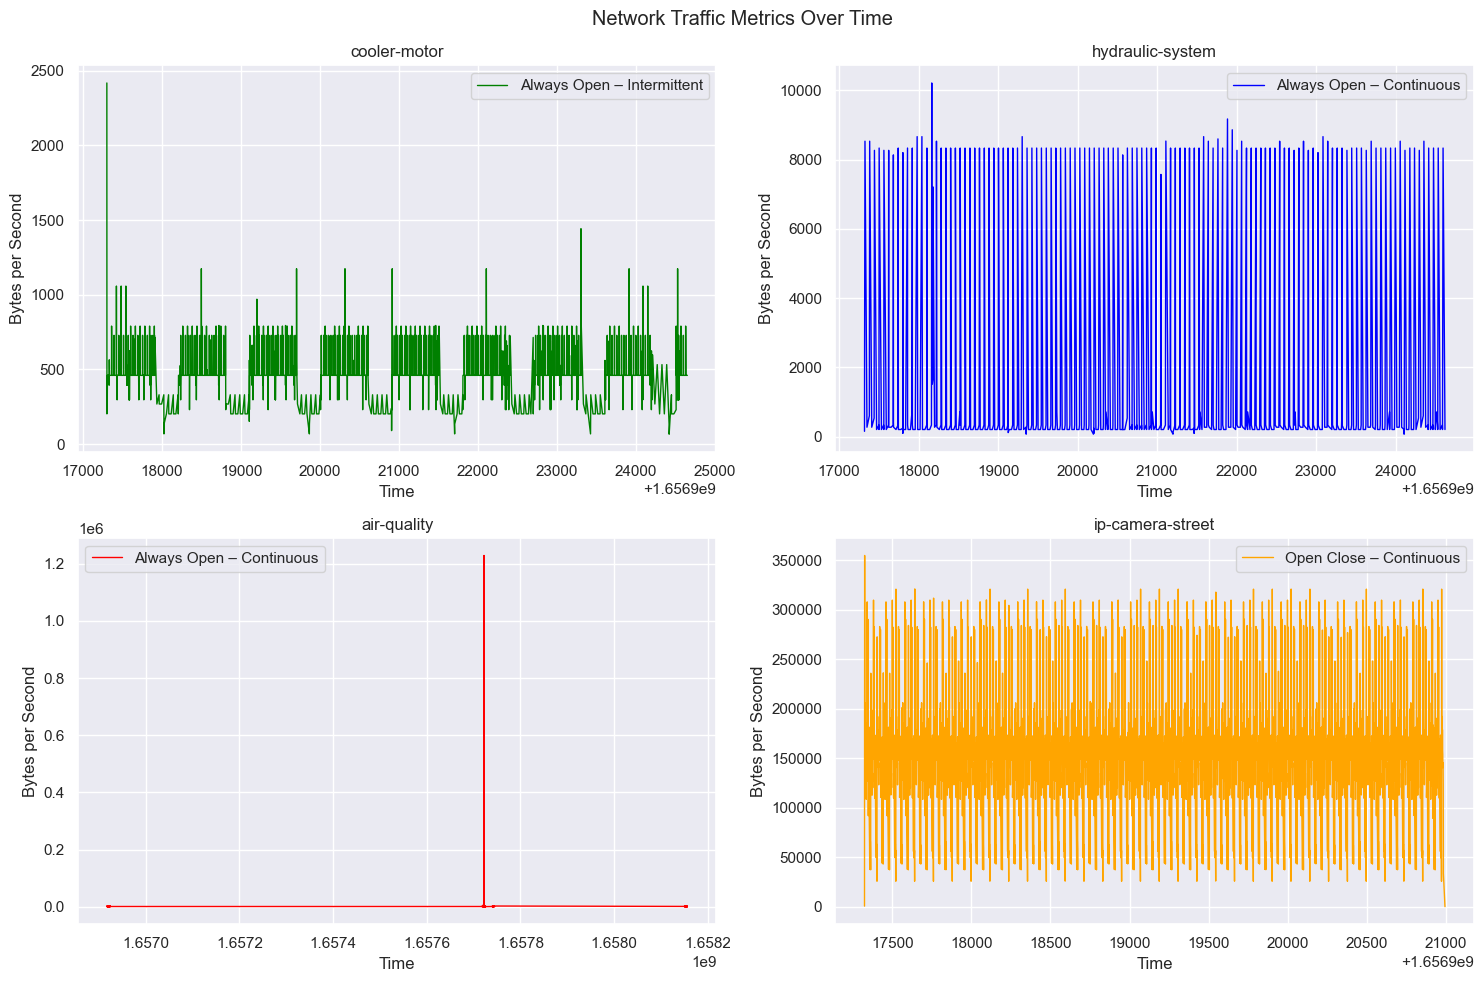

In [35]:
devices = [("iotsim-hydraulic-system-9", "hydraulic-system") ,
           ("iotsim-cooler-motor-8","cooler-motor"),
           ("iotsim-ip-camera-street-2","ip-camera-street"),
           ("iotsim-air-quality-1", "air-quality"),]

sns.set_theme(style="darkgrid", palette="deep")

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Network Traffic Metrics Over Time")

# Plot 1: Bytes per second
labels = ['Always Open – Intermittent', 'Open Close – Continuous', 
          'Always Open – Continuous', 'Always Open – Continuous']
colors = ['blue', 'green', 'orange', 'red']
for i, (device, device_name) in enumerate(devices):
    data = final_df[(final_df.device == device)]
    data['frame.time'] = data['frame.time'].str.replace('  ', ' ')
    data['frame.time'] = data['frame.time'].str.replace(' BST', '')
    data['timestamp'] = pd.to_datetime(data['frame.time'], format="%b %d, %Y %H:%M:%S.%f000")
    data['timestamp'] = data['timestamp'].values.astype(np.int64) // 10 ** 9
    #data.dropna(axis=0, inplace=True, subset=['src_ip', 'dst_ip'])
    # Group by timestamp (per second) and sum packet sizes within each second
    traffic_volume = data.groupby('timestamp')['frame.len'].sum().reset_index()
    traffic_volume.columns = ['timestamp', 'bytes_per_second']
    
    # Convert timestamp to datetime for easier plotting
    # traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

    x, y = i//2, i%2-1
    sns.lineplot(ax=axes[x, y], x='timestamp', y='bytes_per_second', data=traffic_volume, color=colors[i], linewidth=1, label=labels[i-1])
    axes[x, y].set_title(f"{device_name}")
    axes[x, y].set_xlabel("Time")
    axes[x, y].set_ylabel("Bytes per Second")

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.savefig("network_traffic_metrics_0.png", dpi=300, bbox_inches='tight')
plt.show()

### IoT Device Type

In [4]:
number_of_device = df.device.nunique()
number_of_device_types = df.device_type.nunique()
packet_distribution_per_device = df.device.value_counts()
packet_distribution_per_device_type = df.device_type.value_counts()
bytes_transmitted_per_device = df.groupby("device_type")["packet_size"].sum()

### Protocols

In [5]:
packets_per_protocol = df.protocol.value_counts()
packets_per_protocol_per_device = df.groupby("device_type")['protocol'].value_counts()

### Traffic Volume Pattern

In [6]:
## Sending – Receiving

In [38]:
0//2, 0%2-1

(0, -1)

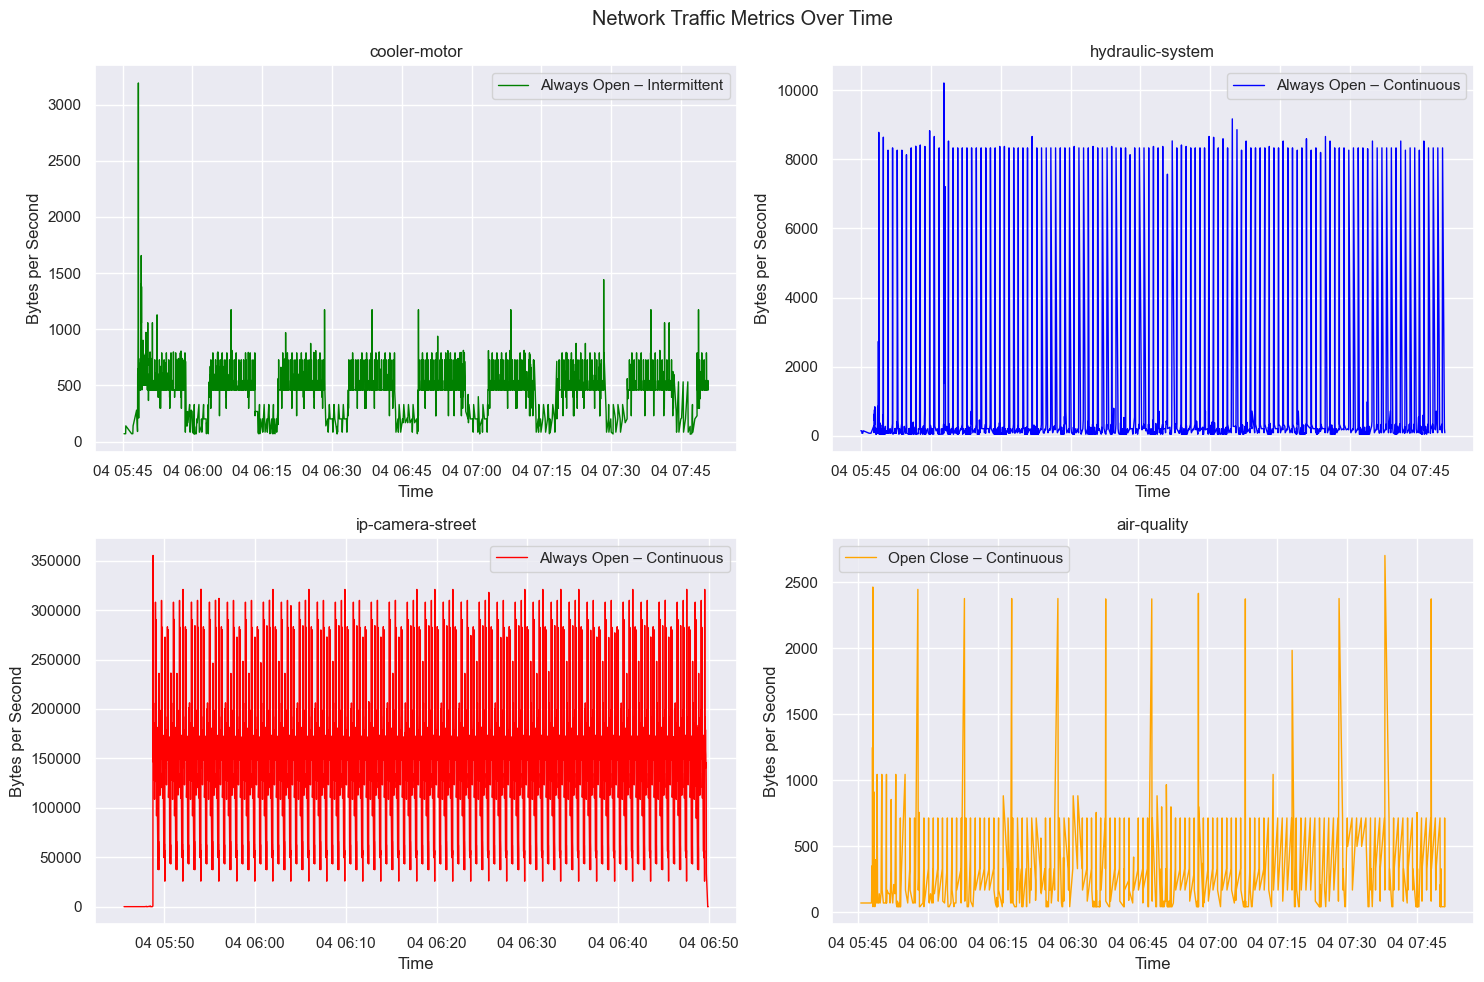

In [6]:
devices = [("iotsim-hydraulic-system-9_0-0_to_OpenvSwitch-15_9-0.pcap", "hydraulic-system") ,
           ("iotsim-cooler-motor-8_0-0_to_OpenvSwitch-18_8-0.pcap","cooler-motor"),
           ("iotsim-air-quality-1_0-0_to_OpenvSwitch-25_1-0.pcap", "air-quality"),
           ("iotsim-ip-camera-street-2_0-0_to_OpenvSwitch-24_2-0.pcap","ip-camera-street")]

sns.set_theme(style="darkgrid", palette="deep")

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Network Traffic Metrics Over Time")

# Plot 1: Bytes per second
labels = ['Always Open – Intermittent', 'Open Close – Continuous', 
          'Always Open – Continuous', 'Always Open – Continuous']
colors = ['blue', 'green', 'orange', 'red']
for i, (device, device_name) in enumerate(devices):
    data = df[(df.device == device)]
    #data.dropna(axis=0, inplace=True, subset=['src_ip', 'dst_ip'])
    # Group by timestamp (per second) and sum packet sizes within each second
    traffic_volume = data.groupby('timestamp')['packet_size'].sum().reset_index()
    traffic_volume.columns = ['timestamp', 'bytes_per_second']
    
    # Convert timestamp to datetime for easier plotting
    traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

    x, y = i//2, i%2-1
    sns.lineplot(ax=axes[x, y], x='timestamp', y='bytes_per_second', data=traffic_volume, color=colors[i], linewidth=1, label=labels[i-1])
    axes[x, y].set_title(f"{device_name}")
    axes[x, y].set_xlabel("Time")
    axes[x, y].set_ylabel("Bytes per Second")

    # Plot traffic volume over time
    #plt.subplot(2, 2, i)
    #plt.plot(traffic_volume['timestamp'], traffic_volume['bytes_per_second'], color='blue')
    #plt.title(f"{device_name}")
    #plt.xlabel("Time")
    #plt.ylabel("Bytes per Second")
    
plt.tight_layout()  # Adjust layout to avoid overlapping
plt.savefig("network_traffic_metrics_0.png", dpi=300, bbox_inches='tight')
plt.show()


## Always Open – Continuous
## Always Open – Intermittent
## Open Close – Continuous

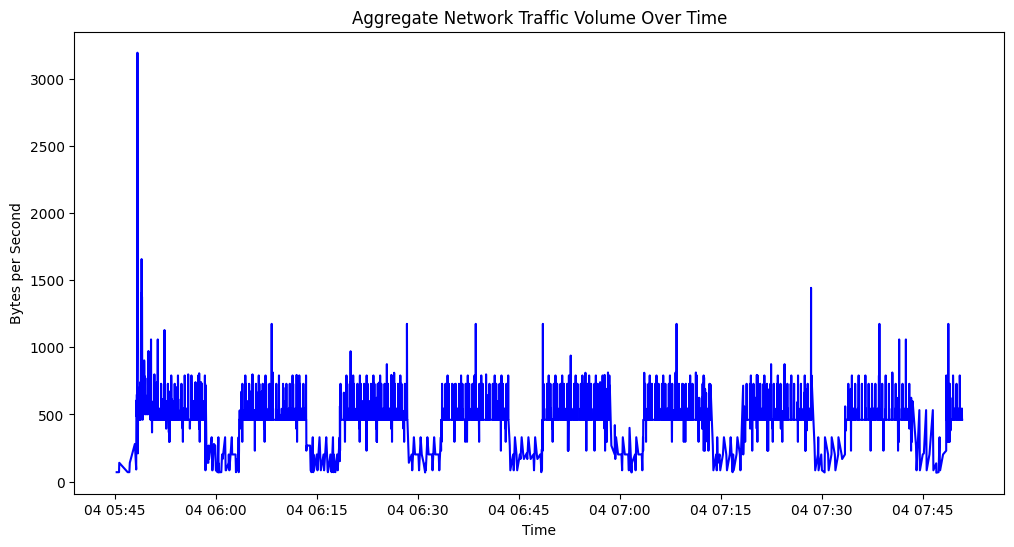

In [79]:
data = df[df.device == "iotsim-cooler-motor-8_0-0_to_OpenvSwitch-18_8-0.pcap"]

# Group by timestamp (per second) and sum packet sizes within each second
traffic_volume = data.groupby('timestamp')['packet_size'].sum().reset_index()
traffic_volume.columns = ['timestamp', 'bytes_per_second']

# Convert timestamp to datetime for easier plotting
traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

# Plot traffic volume over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_volume['timestamp'], traffic_volume['bytes_per_second'], color='blue')
plt.title("Aggregate Network Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes per Second")
plt.show()

## Always Open – Intermittent

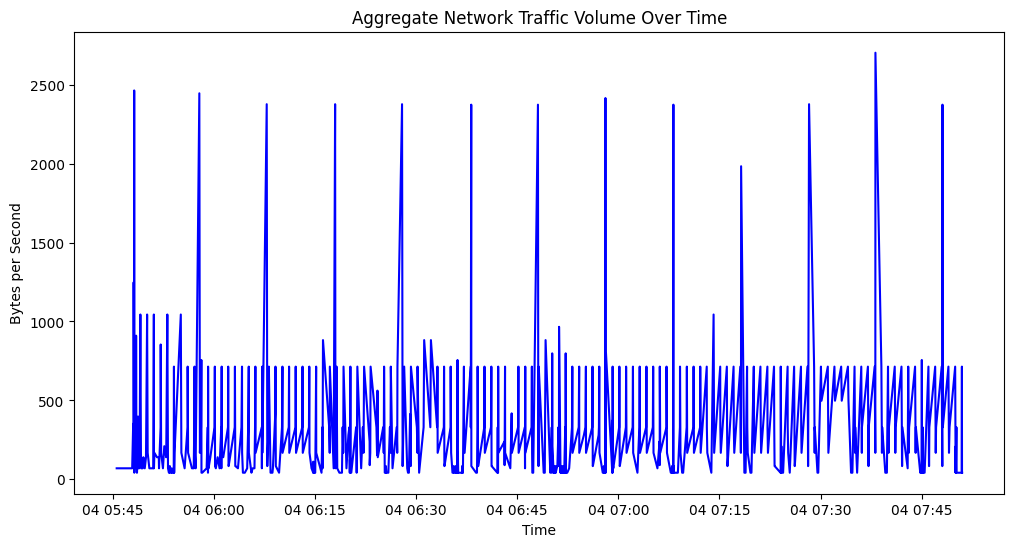

In [85]:
data = df[df.device == "iotsim-air-quality-1_0-0_to_OpenvSwitch-25_1-0.pcap"]

# Group by timestamp (per second) and sum packet sizes within each second
traffic_volume = data.groupby('timestamp')['packet_size'].sum().reset_index()
traffic_volume.columns = ['timestamp', 'bytes_per_second']

# Convert timestamp to datetime for easier plotting
traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

# Plot traffic volume over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_volume['timestamp'], traffic_volume['bytes_per_second'], color='blue')
plt.title("Aggregate Network Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes per Second")
plt.show()

## Open Close – Continuous

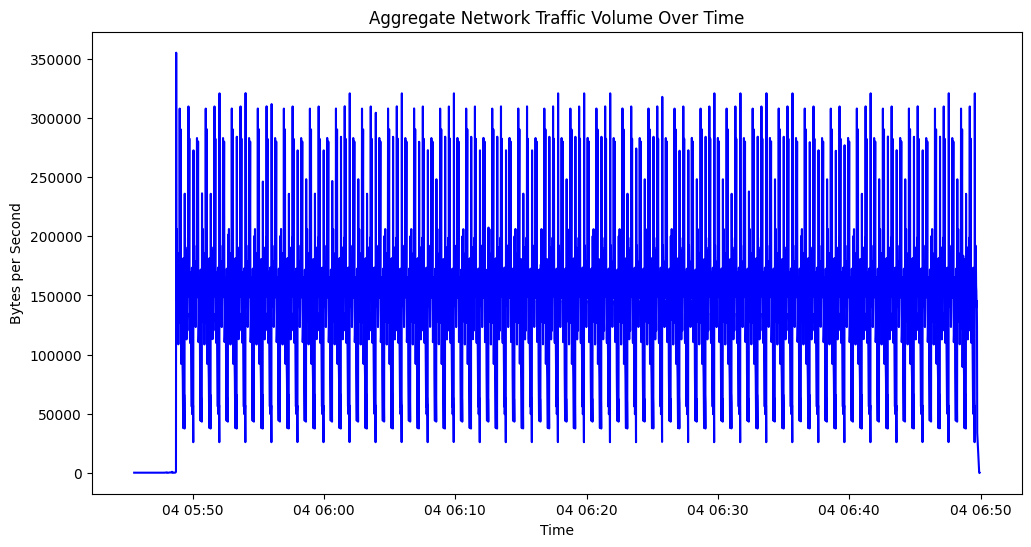

In [81]:
data = df[df.device == "iotsim-ip-camera-street-2_0-0_to_OpenvSwitch-24_2-0.pcap"]

# Group by timestamp (per second) and sum packet sizes within each second
traffic_volume = data.groupby('timestamp')['packet_size'].sum().reset_index()
traffic_volume.columns = ['timestamp', 'bytes_per_second']

# Convert timestamp to datetime for easier plotting
traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

# Plot traffic volume over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_volume['timestamp'], traffic_volume['bytes_per_second'], color='blue')
plt.title("Aggregate Network Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes per Second")
plt.show()

In [60]:
df.groupby("device_type")['packet_size'].value_counts()
## boxplot (min, max, q1, q3)
## packet information per iot device type: x (iot device type) and y (packet size)
## same for flow duration: x (iot device type) and y (flow duration)

device_type             packet_size
iotsim-air-quality      42             880
                        76             414
                        90             276
                        98             250
                        92             138
                                      ... 
iotsim-stream-consumer  251              2
                        306              1
                        342              1
                        443              1
                        577              1
Name: count, Length: 1545, dtype: int64

In [ ]:
data = df[df.device_type == "iotsim-air-quality"]

# Group by timestamp (per second) and sum packet sizes within each second
traffic_volume = data.groupby('timestamp')['packet_size'].sum().reset_index()
traffic_volume.columns = ['timestamp', 'bytes_per_second']

# Convert timestamp to datetime for easier plotting
traffic_volume['timestamp'] = pd.to_datetime(traffic_volume['timestamp'], unit='s')

# Plot traffic volume over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_volume['timestamp'], traffic_volume['bytes_per_second'], color='blue')
plt.title("Aggregate Network Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes per Second")
plt.show()

In [38]:
# General Packet Statistics

## Total Packets: Number of packets in the dataset.
total_packets = df.shape[0]
#print(f"Total Number of Packets: {total_packets}\n\n")

## Packet Count by Protocol: Total packets for each protocol (e.g., TCP, UDP, ICMP).
packets_per_protocol = df.protocol.value_counts()
#print(f"Total Number of Protocols: {df.protocol.nunique()}\n\n")
#print(f"Protocols: {df.protocol.unique()}\n\n")

## Average Packet Size: Mean size of packets.
#size_packet_info = df.packet_size.describe()
average_packet_size = df.packet_size.mean()
total_bytes = df.packet_size.sum()

## Protocol Distribution: Distribution of packets across protocols as a percentage of the total packet count


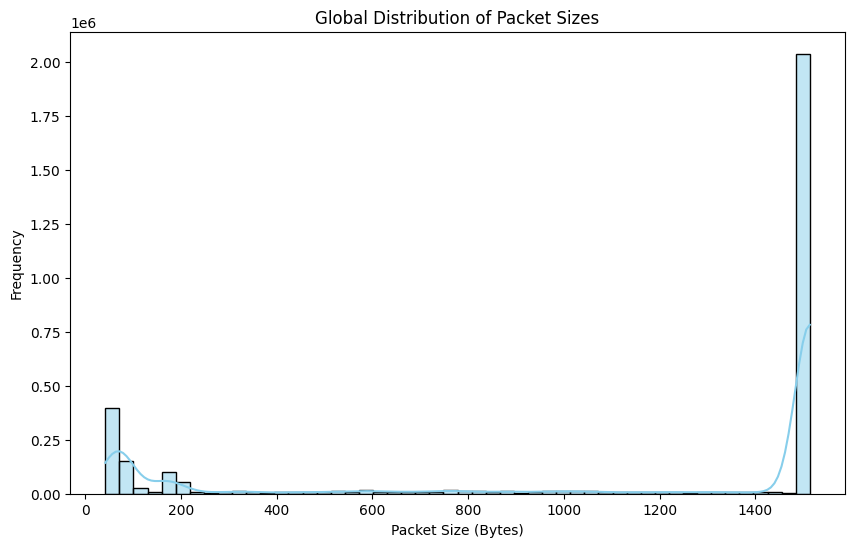

In [115]:
# Plot histogram and KDE for packet sizes
plt.figure(figsize=(10, 6))
sns.histplot(df['packet_size'], bins=50, kde=True, color='skyblue', edgecolor='black')

# Labeling the plot
plt.title("Global Distribution of Packet Sizes")
plt.xlabel("Packet Size (Bytes)")
plt.ylabel("Frequency")
plt.show()

In [7]:
# For discrete values (categories)
probs = df['protocol'].value_counts(normalize=True)
entropy_value = entropy(probs)

# For continuous values (discretize into bins)
hist, bin_edges = np.histogram(df['protocol'], bins=10, density=True)
entropy_value = entropy(hist)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

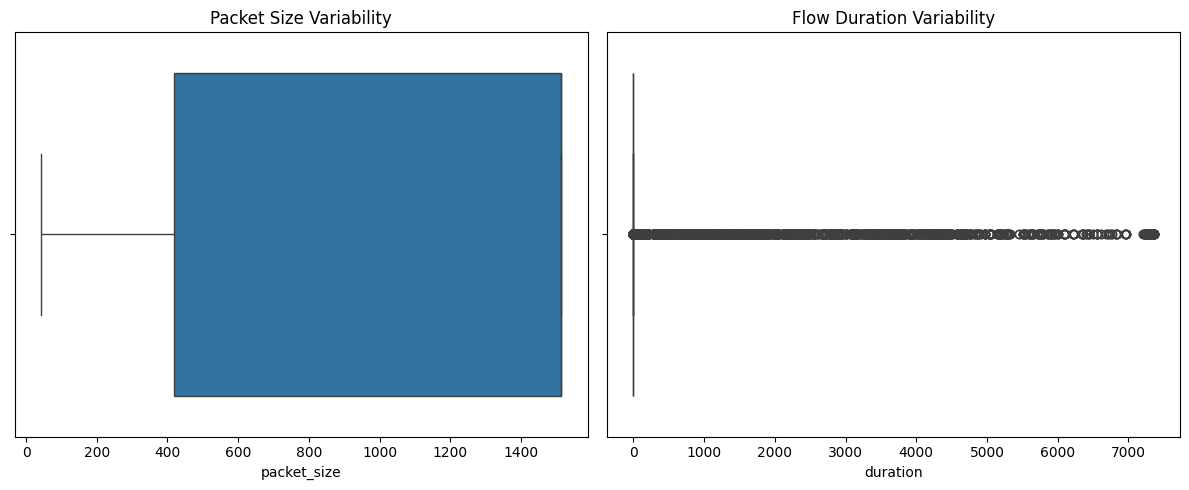

In [134]:
# Box plots for Packet Size and Flow Duration
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot for Packet Size
sns.boxplot(x=df['packet_size'], ax=axes[0])
axes[0].set_title('Packet Size Variability')

# Box plot for Flow Duration
sns.boxplot(x=flow_durations['duration'], ax=axes[1])
axes[1].set_title('Flow Duration Variability')

plt.tight_layout()
plt.show()

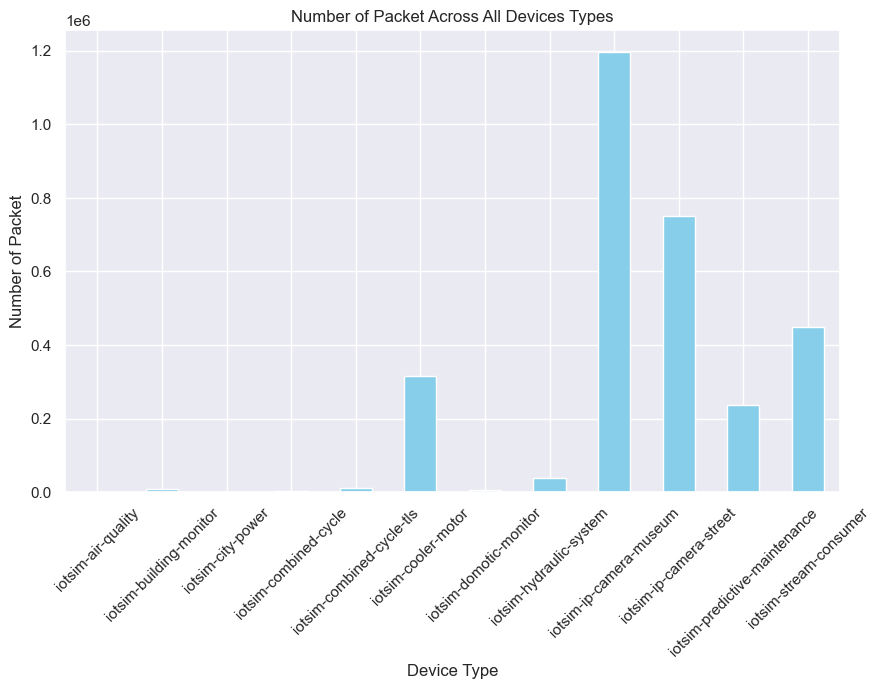

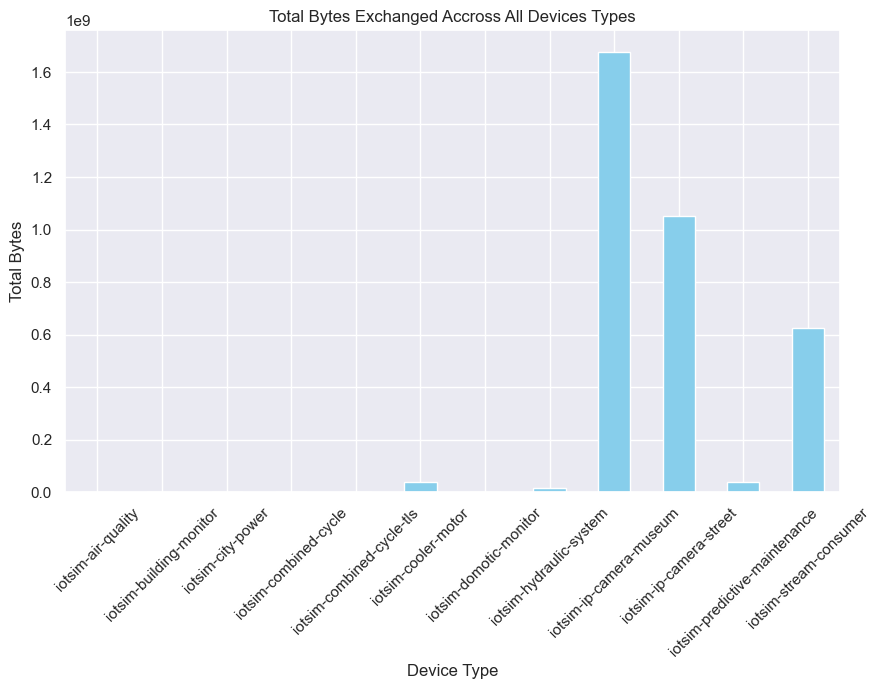

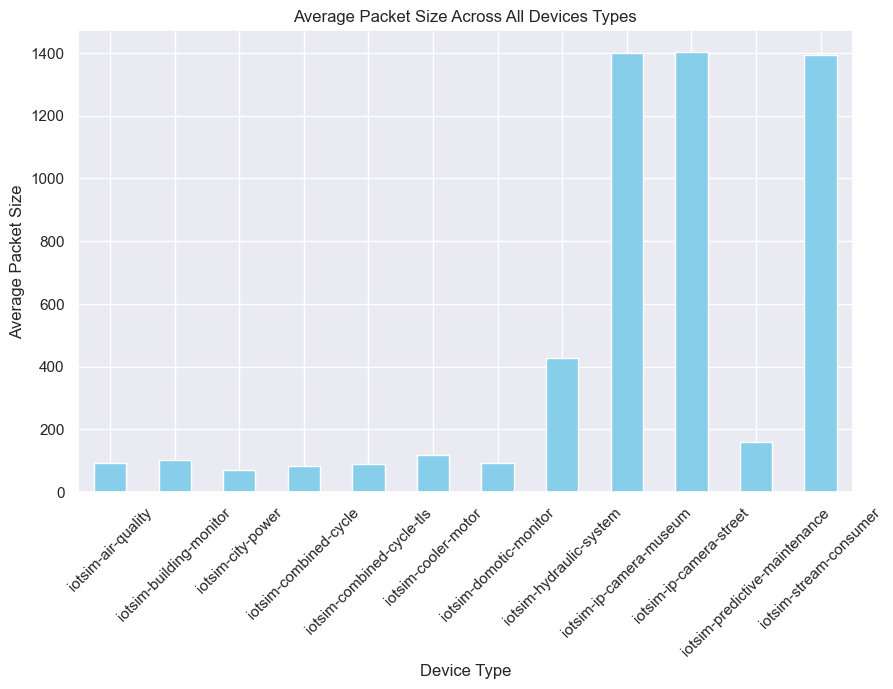

In [49]:
# Plot protocol distribution
plt.figure(figsize=(10, 6))
df.groupby("device_type")["packet_size"].count().plot(kind='bar', color='skyblue')
plt.title("Number of Packet Across All Devices Types")
plt.xlabel("Device Type")
plt.ylabel("Number of Packet")
plt.xticks(rotation=45)
plt.savefig("network_traffic_metrics_1.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot protocol distribution
plt.figure(figsize=(10, 6))
df.groupby("device_type")["packet_size"].sum().plot(kind='bar', color='skyblue')
plt.title("Total Bytes Exchanged Accross All Devices Types")
plt.xlabel("Device Type")
plt.ylabel("Total Bytes")
plt.xticks(rotation=45)
plt.savefig("network_traffic_metrics_2.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot protocol distribution
plt.figure(figsize=(10, 6))
df.groupby("device_type")["packet_size"].mean().plot(kind='bar', color='skyblue')
plt.title("Average Packet Size Across All Devices Types")
plt.xlabel("Device Type")
plt.ylabel("Average Packet Size")
plt.xticks(rotation=45)
plt.savefig("network_traffic_metrics_3.png", dpi=300, bbox_inches='tight')
plt.show()

# Identify unique flows by grouping
# A flow is identified by src_ip, dst_ip, src_port, dst_port, and protocol
df.dropna(axis=0, inplace=True)
df['timestamp'] = df['timestamp'].astype(float)
flows = df.groupby(['device_type', 'src_ip', 'dst_ip', 'protocol', 'src_port', 'dst_port'])

In [25]:
# Calculate flow duration
flow_durations = flows['timestamp'].agg(['min', 'max', 'count', 'mean'])
flow_durations['duration'] = flow_durations['max'] - flow_durations['min']
flow_durations['count'] = flow_durations['count']

# Calculate total counts and average duration of flows
total_flows = flow_durations.shape[0]
average_duration = flow_durations['duration'].mean()

In [133]:
flow_durations['duration']

min  \
device_type            src_ip                    dst_ip                    protocol src_port dst_port                 
iotsim-air-quality     192.168.0.2               192.168.18.17             DNS      53.0     32818.0   1.656918e+09   
                                                                                             32827.0   1.656917e+09   
                                                                                             32876.0   1.656915e+09   
                                                                                             32970.0   1.656915e+09   
                                                                                             33068.0   1.656918e+09   
...                                                                                                             ...   
iotsim-stream-consumer 192.168.17.18,192.168.1.2 192.168.1.2,192.168.17.18 ICMP     8000.0   19882.0   1.656917e+09   
                                                                                             21956.0   1.656917e+09   
                                                                                             22792.0   1.656916e+09   
                                                                                             26058.0   1.656916e+09   
                                                                                             31264.0   1.656914e+09   

                                                                                                                max  \
device_type            src_ip                    dst_ip                    protocol src_port dst_port                 
iotsim-air-quality     192.168.0.2               192.168.18.17             DNS      53.0     32818.0   1.656918e+09   
                                                                                             32827.0   1.656917e+09   
                                                                                             32876.0   1.656915e+09   
                                                                                             32970.0   1.656915e+09   
                                                                                             33068.0   1.656918e+09   
...                                                                                                             ...   
iotsim-stream-consumer 192.168.17.18,192.168.1.2 192.168.1.2,192.168.17.18 ICMP     8000.0   19882.0   1.656917e+09   
                                                                                             21956.0   1.656917e+09   
                                                                                             22792.0   1.656916e+09   
                                                                                             26058.0   1.656916e+09   
                                                                                             31264.0   1.656914e+09   

                                                                                                       count  \
device_type            src_ip                    dst_ip                    protocol src_port dst_port          
iotsim-air-quality     192.168.0.2               192.168.18.17             DNS      53.0     32818.0       1   
                                                                                             32827.0       1   
                                                                                             32876.0       2   
                                                                                             32970.0       2   
                                                                                             33068.0       1   
...                                                                                                      ...   
iotsim-stream-consumer 192.168.17.18,192.168.1.2 192.168.1.2,192.168.17.18 ICMP     8000.0   19882.0       2   
        

In [ ]:
df.stream_id.unique()

In [111]:
df['stream_id'] = -1
for device in df['device']:
    df_filtered = df[df['device'] == device]
    stream_id = 0
    previous_packet_flow = ("", "", "", "")
    for row_id, (_, _, _, protocol, src_ip, dst_ip, src_port, dst_port, _, _) in df_filtered.iterrows():
        if protocol in ["DNS", "NTP"]:
            continue
        
        if ((src_ip, dst_ip, src_port, dst_port) == previous_packet_flow) or \
            ((dst_ip, src_ip, src_port, dst_port) == previous_packet_flow) or \
            ((src_ip, dst_ip, dst_port, src_port) == previous_packet_flow) or \
            ((dst_ip, src_ip, dst_port, src_port) == previous_packet_flow):
            df.loc[row_id, 'stream_id'] = stream_id

        else:
            stream_id += 1
            df.loc[row_id, 'stream_id'] = stream_id

        previous_packet_flow = (src_ip, dst_ip, src_port, dst_port)

KeyboardInterrupt: 

In [ ]:
# Packet Analysis |

## Traffic Volume
## Top Protocols
## Top Ports
## Top IoT Device (IP-address)
## Packets per Second
## Packet Length
## 

# Flow Analysis |

## # of Flows
## # Packets per Flow
## Flow Duration
## 
